# Check out Troilite agreement with VY 1995

http://adsabs.harvard.edu/abs/2017arXiv170905359R

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

from minerals import Mineral
import abundances
import VY1995

In [3]:
troilite = Mineral({'Fe':1.0, 'S':1.0}, name='Troilite')

In [4]:
dust_mass_ratio = 0.01 # dust to gas mass ratio
NH = 1.e22 * u.Unit('cm^-2')
MD = NH * c.m_p.to('g') * dust_mass_ratio

In [5]:
troil_xsect = Table.read('FeK_Rogantini/tabs_CDS/sample/troilite.dat', format='ascii', header_start=2, data_start=3)

In [6]:
troil_xsect.colnames

['energy', 'extinction', 'scattering', 'absorption']

In [10]:
def FeK_xsect(keyword, tbl):
    assert keyword in tbl.colnames[1:]
    energy = tbl['energy'] * u.keV
    result = tbl[keyword] * u.Unit('cm^2')
    return energy, result

In [11]:
ener, exti = FeK_xsect('extinction', troil_xsect)
_, scat = FeK_xsect('scattering', troil_xsect)
_, abso = FeK_xsect('absorption', troil_xsect)

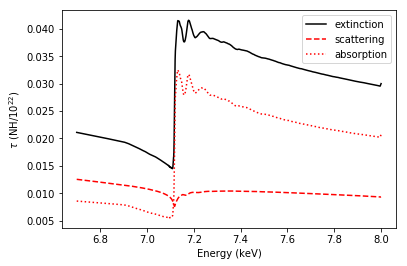

In [12]:
plt.plot(ener, exti * NH, color='k', label='extinction')
plt.plot(ener, scat * NH, color='r', ls='--', label='scattering')
plt.plot(ener, abso * NH, color='r', ls=':', label='absorption')
plt.xlabel('Energy ({})'.format(ener.unit))
plt.ylabel(r'$\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')

## Compare this to ISMdust

In [14]:
import os
from astropy.io import fits

ismdust_sil_filename = os.environ['ISMDUSTROOT'] + 'edge_files/silicate_xs.fits'

In [15]:
ismdust_sil = fits.open(ismdust_sil_filename)

In [16]:
## Note the parameters that were used to produce the ISMdust model
ismdust_sil[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
AMIN    = '0.005   '                                                            
AMAX    = '0.300   '                                                            
P       = '3.500   '                                                            
RHO     = '3.800   '                                                            
MDUST   = '1.00e-04'                                                            
GTYPE   = 'Silicate'                                                            
COMMENT Created by liac@umich.edu on 2018-06-25                                 

In [17]:
ismdust_sil[1].data.columns

ColDefs(
    name = 'energy'; format = 'E'
    name = 'angstroms'; format = 'E'
    name = 'ext'; format = 'E'
    name = 'sca'; format = 'E'
    name = 'abs'; format = 'E'
)

In [18]:
def sil_xsect(keyword, fitsfile):
    fits_tbl = fitsfile[1].data
    mdust = np.float(fitsfile[0].header['MDUST']) * u.Unit('g cm^-2')
    assert keyword in fits_tbl.columns.names[2:]
    energy = fits_tbl['energy'] * u.keV
    result = fits_tbl[keyword] / mdust
    return energy, result.to(u.Unit('g^-1 cm^2'))

In [19]:
ener2, exti2 = sil_xsect('ext', ismdust_sil)
_, scat2 = sil_xsect('sca', ismdust_sil)
_, abso2 = sil_xsect('abs', ismdust_sil)

(0, 0.08)

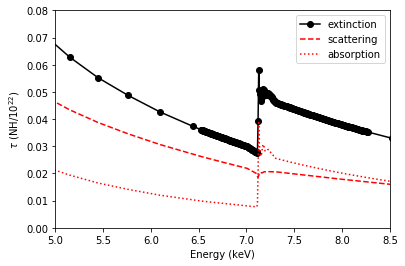

In [20]:
## One can see that ISMdust was not calculated at high resolution in this region
## Mainly because the target was gratings data, which has evenly spaced resolution in angstrom
plt.plot(ener2, exti2 * MD, color='k', marker='o', label='extinction')
plt.plot(ener2, scat2 * MD, color='r', ls='--', label='scattering')
plt.plot(ener2, abso2 * MD, color='r', ls=':', label='absorption')
plt.xlabel('Energy ({})'.format(ener.unit))
plt.ylabel(r'$\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.08)

# Compare extinction and absorption from all models

## 1. Extinction

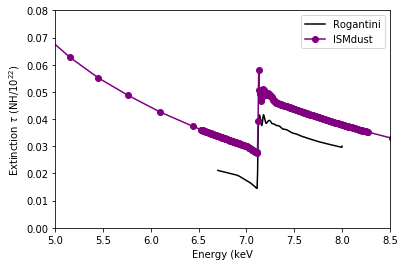

In [21]:
plt.plot(ener, exti * NH, color='k', label='Rogantini')
plt.plot(ener2, exti2 * MD, color='purple', marker='o', label='ISMdust')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.08)
plt.legend(loc='upper right')
plt.xlabel('Energy ({}'.format(ener.unit))
plt.ylabel(r'Extinction $\tau$ (NH/10$^{22}$)')
plt.savefig('compare_extinction.pdf', format='pdf')

## 2. Absorption

Also compare with expecations from Verner & Yaklovev (1995) absorption

In [23]:
# mass of unit cell
troilite_unit_mass = sum([troilite.number(ele) * abundances.amu[ele] * c.u.to('g') for ele in troilite.elements])

# number of olivine unit cells per NH=1e22 column density
troilite_dens = MD / troilite_unit_mass

In [24]:
# calculate cross-section component (area) from each element in olivine
xsects = {ele:VY1995.compute_xsect(ener2, abundances.Z[ele], 0) * troilite.number(ele)
          for ele in troilite.elements}

# sum to obtain the cross-section per unit cel
total_xsect = np.zeros(len(ener2)) * u.Unit('cm^2')
for ele in xsects.keys():
    total_xsect += xsects[ele].to('cm^2')

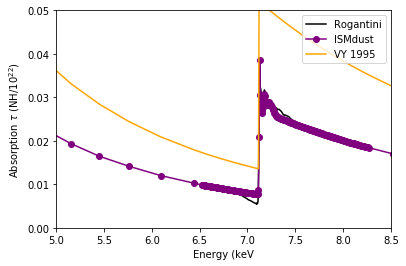

In [66]:
plt.plot(ener, abso * NH, color='k', label='Rogantini')
plt.plot(ener2, abso2 * MD, color='purple', marker='o', label='ISMdust')
plt.plot(ener2, total_xsect * troilite_dens, color='orange', label='VY 1995')
plt.xlim(5.0, 8.5)
plt.ylim(0, 0.05)
plt.legend(loc='upper right')
plt.xlabel('Energy ({}'.format(ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.savefig("compare_troilite.pdf", format='pdf')

### Piece together an ISM absorption cross-section

In [27]:
# Making a function out of the above
# does not take dust grain shielding into account (see Wilms 2000)
def calculate_pure_absorption(energy, mineral, md=MD):
    unit_mass = sum([mineral.number(ele) * abundances.amu[ele] * c.u.to('g')
                     for ele in mineral.elements])
    number_dens = md / unit_mass
    xsects = {ele:VY1995.compute_xsect(energy, abundances.Z[ele], 0) * mineral.number(ele)
              for ele in mineral.elements}
    result = np.zeros(len(energy)) * u.Unit('cm^2')
    for ele in mineral.elements:
        result += xsects[ele].to('cm^2')
    return result

In [28]:
# Make a final energy grid
new_abs_ener = np.append(np.append(np.append(
    ener2[ener2 < ener[0]].value, 
    ener.value), 
    ener2[ener2 > ener[-1]].value), 
    np.arange(ener2[-1].value + 0.1, 300.01, 0.1)) * u.keV

# mask for energy values used in Rogantini cross-section
rog_eners = (new_abs_ener >= ener[0]) & (new_abs_ener <= ener[-1])

In [30]:
# Evaluate VY 1995 on that grid
vy95_abs = calculate_pure_absorption(new_abs_ener, troilite, md=MD)

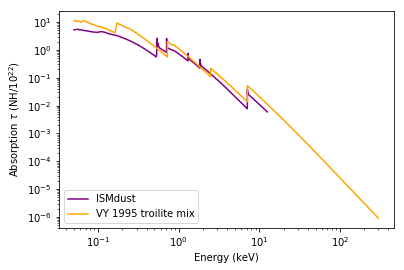

In [33]:
plt.plot(ener2, abso2 * MD, color='purple', label='ISMdust')
plt.plot(new_abs_ener, vy95_abs * troilite_dens, color='orange', label='VY 1995 troilite mix')
plt.loglog()
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='lower left')

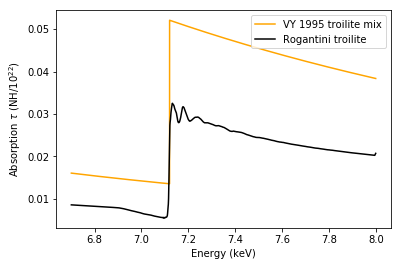

In [35]:
plt.plot(new_abs_ener[rog_eners], vy95_abs[rog_eners] * troilite_dens, color='orange', label='VY 1995 troilite mix')
plt.plot(ener, abso * NH, color='k', label='Rogantini troilite')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')

Rescale the Rogantini cross-section to match VY 1995 on the left and right side

In [63]:
# depth of VY 1995 
case_a_vy  = (vy95_abs[rog_eners][-1] - vy95_abs[rog_eners][0]) * troilite_dens

# depth of Rogantini
case_a_rog = (abso[-1] - abso[0]) * NH

# rescaled rogantini cross-section
abso_rescale = ((abso - abso[0]) * (case_a_vy/case_a_rog) * NH + vy95_abs[rog_eners][0] * troilite_dens) / NH

# renormed roganitini cross-section
abso_renorm = (vy95_abs[rog_eners][0] * troilite_dens - abso[0] * NH) + abso * NH

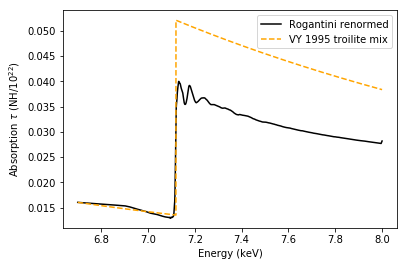

In [67]:
plt.plot(ener, abso_renorm, color='k', label='Rogantini renormed')
plt.plot(new_abs_ener[rog_eners], vy95_abs[rog_eners] * troilite_dens, 
         color='orange', ls='--', label='VY 1995 troilite mix')
plt.xlabel('Energy ({})'.format(new_abs_ener.unit))
plt.ylabel(r'Absorption $\tau$ (NH/10$^{22}$)')
plt.legend(loc='upper right')
plt.savefig('troilite_rescale.pdf', format='pdf')